# Aims of this script

1. Time-series visualisation of water levels
2. Calculating single value to use for interpolation approach
3. Any other time series analysis
4. Select data for water table mapping exercise
5. Variogram generation

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [2]:
figures_directory = r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures'

## Set up data

In [3]:
SAWaCoFolder = r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\input_data\McLaren_SAWaterConnect'
constr_details_df = pd.read_csv(os.path.join(SAWaCoFolder, 'constructiondetails.csv'))
water_level_df = pd.read_csv(os.path.join(SAWaCoFolder, 'waterlevel.csv'))
well_summary_df = pd.read_csv(os.path.join(SAWaCoFolder, 'wellsummary.csv'))

outputdatapath = r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\output_data'

## Have a look at the well summary data and change index

In [4]:
well_summary_df.head(2)
print(well_summary_df.columns)
well_summary_df.index = well_summary_df.DHNO
print(well_summary_df.index)

Index(['DHNO', 'Unit_No', 'Unit_Number', 'dh_name', 'network', 'Obs_No',
       'drillhole_class', 'water_point_type_code', 'Aquifer',
       'Orig_drilled_depth', 'Orig_drilled_date', 'max_drill_depth',
       'max_drill_date', 'late_open_depth', 'late_open_date', 'late_permit_no',
       'cased_to', 'case_min_diam', 'purpose', 'latest_status',
       'latest_status_date', 'dtw', 'swl', 'rswl', 'water_level_date', 'TDS',
       'EC', 'salinity_date', 'pH', 'pH_date', 'yield', 'yield_date',
       'mga_easting', 'mga_northing', 'mga_zone', 'long_degrees',
       'long_minutes', 'long_seconds', 'lat_degrees', 'lat_minutes',
       'lat_seconds', 'decimal_long', 'decimal_lat', 'neg_decimal_lat',
       'hundred', 'plan', 'parcel', 'Title', 'map_250k', 'map_100k', 'map_50k',
       'map_10k', 'map_2_5k', 'map_1k', 'water_info', 'salinity',
       'water_chemistry', 'geophys_log', 'drill_log', 'lith_log'],
      dtype='object')
Int64Index([ 26532,  26542,  26547,  26548,  26558,  26565,  2

## Make the well summary into a geodataframe 

This allows for spatial plotting

In [5]:
well_summary_df["geometry"] = [Point(x, y) for x, y in zip(well_summary_df.mga_easting, well_summary_df.mga_northing)]

well_summary_gdf = gpd.GeoDataFrame(well_summary_df, geometry='geometry', crs= 'epsg:32754')

#print(well_summary_gdf.head(2))

C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


## Have a look at the water level data and change the index 

Also change the format of the date time column for time-series analysis

In [6]:
water_level_df.head(1)

water_level_df.index = water_level_df.DHNO

print(water_level_df.index)

water_level_df["Datetime"] = pd.to_datetime(water_level_df["obs_date"])
#print(water_level_df["Datetime"])

Int64Index([ 26532,  26532,  26532,  26532,  26532,  26532,  26532,  26532,
             26532,  26532,
            ...
            200678, 200678, 200678, 200678, 200678, 200678, 200678, 200678,
            200678, 200679],
           dtype='int64', name='DHNO', length=24347)


## Create plots of water levels

Ensure only plotting where there are data - some of the wells there are no time series water level data available.

Save the plots in the figures directory.

In [8]:
idx = well_summary_df.index[0]

for idx in well_summary_df.index:
    #print(idx)

    df = water_level_df.copy()
    df = df[df["DHNO"]==idx]
    #print(df["rswl"])
    #print(df["rswl"].isnull())

    if (len(df) > 0) and (sum(~df["rswl"].isnull())>0):
        #print("Some data exist")
        #print(len(df))
        fig, axes = plt.subplots(1,1)
        df.plot("Datetime", "rswl", ax=axes, marker='+', ls="--",
                        markeredgecolor="0.1", label = idx) 
        #ax1.set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2020-01-01'))
        axes.set_ylabel("RSWL (m AHD)")
        nm = "wl_%s" %idx
        plt.savefig(os.path.join(figures_directory, nm))
        plt.close()
    else:
        #print("No data available for well: %s" %idx)
        pass

## Plot location of wells

Text(84.43555954403271, 0.5, 'Northing')

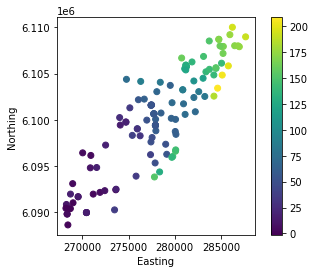

In [9]:
well_summary_gdf.plot(column="rswl", legend=True)
plt.xlabel("Easting")
plt.ylabel("Northing")

## Need to change the obs date to date time format 

This allows me to easily select samples only at/after/between specific time periods.  
First I need to first remove NAN values.  
ss = "sub-set" this is the subset of values corresponding to the time period I choose for the map.

In [10]:
well_summary_gdf_ss = well_summary_gdf.copy()

well_summary_gdf_ss = well_summary_gdf_ss[well_summary_gdf_ss['water_level_date'].notna()]

print("Number of samples including nan values:" + str(len(well_summary_gdf)))
print("Number of samples exlcuding nan values:" + str(len(well_summary_gdf_ss)))

well_summary_gdf_ss["Datetime"] = pd.to_datetime(well_summary_gdf_ss["water_level_date"])

Number of samples including nan values:148
Number of samples exlcuding nan values:140


## Only get dates that are this year - so that they are consistent


In [11]:
startdate = '2021-01-01 00:00:00'

print("Total number of measurements, any time period %i" %(len(well_summary_gdf_ss)))
well_summary_gdf_ss = well_summary_gdf_ss[well_summary_gdf_ss['Datetime'] > startdate]
print("Number of measurements after %s: %i" %(startdate[0:10], len(well_summary_gdf_ss)))

Total number of measurements, any time period 140
Number of measurements after 2021-01-01: 85


## Filter out empty values that don't have a rswl

In [12]:
well_summary_gdf_ss = well_summary_gdf_ss[well_summary_gdf_ss['rswl'].isnull() == False]

print("Number of measurements after %s & with a rswl measurement: %i" %(startdate[0:10], len(well_summary_gdf_ss)))

Number of measurements after 2021-01-01 & with a rswl measurement: 81


### Plot the location of wells in 2021 with data for rswl

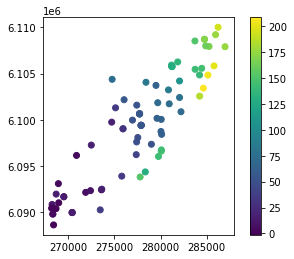

In [13]:
well_summary_gdf_ss.plot(column="rswl", legend=True)

plt.savefig(os.path.join(figures_directory, "2021_data"), dpi=300)

## Look at the aquifers that these wells are in 

N = Neoproterozoic
Qpa = Pleistocene alluvial/fluvial sediments
Qpam = Pirramimma Sandstone
Te2 = Eocene unit 2
Teb = Blanche Point Formation
Toc = Chinaman Gully Formation
Tomw =  Port Willunga Formation

McCallum et al (2018) - "The Port Willunga formation is the collective name given to the stratigraphic units that comprise the upper tertiary aqufier of the Willunga Embayment and includes the Aldinga, Ruwarung and Pirramimma Sand Members"

Te2     18
Qpam    18
N       18
Qpa     14
Tomw     9
Teb      3
Toc      1
Name: Aquifer, dtype: int64

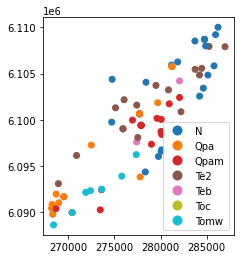

In [14]:
well_summary_gdf_ss.plot(column="Aquifer", legend=True)
well_summary_gdf_ss["Aquifer"].value_counts()

## Filter samples to only have data from particular aquifers

I only want to sample the water table - not the pot surface for deeper/confined aquifers. 

Exclude:
N (too old)
Te2 (assume part of Maslin Sand, confined aquifer)
Teb (this is aquftard between Maslin Sand Aq and Port Willunga Fm)
Toc (this is aquftard between Maslin Sand Aq and Port Willunga Fm)


Include:
Qpa (assume unconfined)

Unsure:
Qpam (Pirramimma Sst is part of Port Willunga Fm)
Tomw (Port Willunga Fm - this is confined, I'm pretty sure it is anyway)

### Quaternary data only

Number of remaining measurements: 14


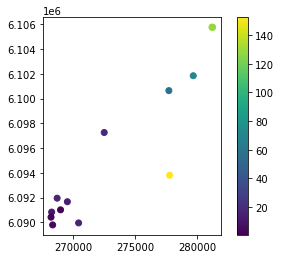

In [15]:
well_summary_gdf_ss2 = well_summary_gdf_ss[well_summary_gdf_ss['Aquifer'] == "Qpa"]

print("Number of remaining measurements: %i" %len(well_summary_gdf_ss2))

well_summary_gdf_ss2.plot(column="rswl", legend=True)

plt.savefig(os.path.join(figures_directory, "2021_data_Qpa"), dpi=300)

### Quaternary + Olig-Miocene data only

Number of remaining measurements: 41


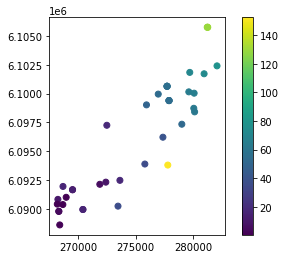

In [16]:
well_summary_gdf_ss3 = well_summary_gdf_ss[(well_summary_gdf_ss['Aquifer'] == "Qpa") | 
                                           (well_summary_gdf_ss['Aquifer'] == "Qpam") |
                                           (well_summary_gdf_ss['Aquifer'] == "Tomw")]

print("Number of remaining measurements: %i" %len(well_summary_gdf_ss3))

well_summary_gdf_ss3.plot(column="rswl", legend=True)

plt.savefig(os.path.join(figures_directory, "2021_data_Q_PtW"), dpi=300)

### Export this dataframe for future reference

In [17]:
well_summary_gdf_ss.to_csv(os.path.join(outputdatapath, "well_summary_gdf_ss.csv"))
well_summary_gdf_ss2.to_csv(os.path.join(outputdatapath, "well_summary_gdf_ss2.csv"))
well_summary_gdf_ss3.to_csv(os.path.join(outputdatapath, "well_summary_gdf_ss3.csv"))

# Remove measurements that look like the aquifers overlap
These wells have been chosen via visual inspection only, this is not idea.
Sites were chosen where there were contradictory deep/shallow values and then I am removing the deep values. This is so that the map is of the unconfined water table aqufier only. 

Also I am working with all of the data - well_summary_gdf_ss

In [18]:
print(well_summary_gdf_ss.index)
wells_to_drop = [27116, 26548, 27099, 27108, 46548, 45807, 166224, 167241]
well_summary_gdf_ss_a = well_summary_gdf_ss.drop(index=wells_to_drop)

Int64Index([ 26548,  26558,  26565,  26585,  27050,  27063,  27099,  27107,
             27108,  27112,  27113,  27116,  27117,  27118,  27119,  27121,
             27125,  39875,  39932,  40002,  40495,  40740,  40794,  42029,
             42104,  42108,  42117,  42173,  42190,  42279,  43439,  43470,
             43490,  44644,  45105,  45276,  45418,  45475,  45807,  46069,
             46129,  46196,  46212,  46229,  46232,  46299,  46548,  46552,
             46725,  46726,  46734,  46736, 131933, 142342, 156132, 166221,
            166224, 166767, 166769, 167241, 177637, 179079, 179080, 180819,
            180820, 180821, 180822, 180835, 180836, 180837, 180838, 182233,
            186362, 195701, 196280, 196571, 196608, 196609, 200676, 200677,
            200678],
           dtype='int64', name='DHNO')


Number of remaining measurements: 73


<AxesSubplot:>

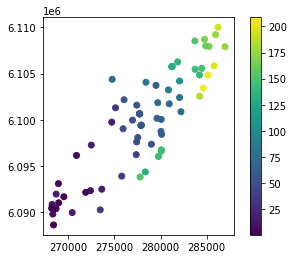

In [19]:
print("Number of remaining measurements: %i" %len(well_summary_gdf_ss_a))

well_summary_gdf_ss_a.plot(column="rswl", legend=True)

## Remove measurements where there are nested wells

First find the duplicates

In [20]:
df_duplicates = well_summary_gdf_ss_a[well_summary_gdf_ss_a.duplicated(subset=['mga_easting','mga_northing'], keep=False)]

print(len(df_duplicates))

print(df_duplicates.mga_easting)
print(df_duplicates.mga_northing)
print(df_duplicates.cased_to)
print(df_duplicates.rswl)

8
DHNO
180819    277727.79
180820    277727.79
180821    277727.79
180822    277727.79
180835    277896.78
180836    277896.78
180837    277896.78
180838    277896.78
Name: mga_easting, dtype: float64
DHNO
180819    6100638.50
180820    6100638.50
180821    6100638.50
180822    6100638.50
180835    6099396.56
180836    6099396.56
180837    6099396.56
180838    6099396.56
Name: mga_northing, dtype: float64
DHNO
180819    36.0
180820    20.8
180821     9.2
180822     3.2
180835    37.0
180836    31.0
180837    21.8
180838     6.6
Name: cased_to, dtype: float64
DHNO
180819    55.69
180820    55.63
180821    55.59
180822    55.58
180835    54.78
180836    54.72
180837    54.32
180838    54.34
Name: rswl, dtype: float64


### Remove duplicates and leave the shallowest wells

In [21]:
type(well_summary_gdf_ss_a.index[0])

numpy.int64

In [22]:
well_summary_gdf_ss_a1 = well_summary_gdf_ss_a.drop(labels=[180819, 180820, 180821, 180837, 180836, 180835])
print(len(well_summary_gdf_ss_a1))

67


Save this data frame

In [23]:
filenm = os.path.join("output_data", "well_summary_gdf_ss_a1.csv")
well_summary_gdf_ss_a1.to_csv(filenm)

# Choose some wells at random to remove
Then the practitioner has to guess the head at these values and we can compare with the real value

In [19]:
import random

n_wells_to_remove = 7

wells_to_guess_i = random.sample(range(0, len(well_summary_gdf_ss_a1)), n_wells_to_remove)
    
print(wells_to_guess_i)

#wells_to_guess_i.append(int(random.uniform(0.0, len(well_summary_gdf_ss_a1)))) - this method can end up with repetition

[7, 34, 41, 4, 24, 42, 33]


# Set the hydraulic head value as empty for these values.
So that I can still have them on the map but not to label wiht the head value

In [29]:
# Because I have already run I just want to keep using these ones
#wells_to_guess_i = [13, 21, 58, 12, 34, 39, 20]
wells_to_guess_idx  = [39875, 42108, 180822, 27125, 46069, 46232, 42104]

well_summary_gdf_ss_b = well_summary_gdf_ss_a1.copy()

idx = well_summary_gdf_ss_b.index

wells_dropped = []

for i in wells_to_guess_idx:
    well_dhno = i
    #print(well_dhno)
    #well_summary_gdf_ss_b = well_summary_gdf_ss_a1.drop(index=well_dhno)
    wells_dropped.append(well_dhno)

print(wells_dropped)

[39875, 42108, 180822, 27125, 46069, 46232, 42104]


For the wells I have dropped, set their value to equal a letter

In [30]:
import string
alphabet = string.ascii_lowercase

for idx, i in zip(wells_dropped, range(len(wells_dropped))):
    well_summary_gdf_ss_b.loc[idx, 'rswl'] = alphabet[i]

In [31]:
#print(len(wells_dropped))
#print(well_summary_gdf_ss_b.rswl)
print(well_summary_gdf_ss_b['rswl'].value_counts()['a'])

1


# Add column to original data frame

So I can "track" which columns I have dropped - for guessing, these have been dropped so I can compare the manual interpolation with the true value.

In [32]:
dropped = []
for i in well_summary_gdf_ss_b.index:
    #print(i)
    if i in wells_dropped:
        dropped.append("Y")
    else:
        dropped.append("N")
        
print(dropped)

['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'Y', 'Y', 'N', 'N', 'N', 'N', 'N', 'N', 'Y', 'Y', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'Y', 'N', 'N', 'N', 'N', 'Y', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'Y', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']


In [33]:
well_summary_gdf_ss_b["dropped"] = dropped

<AxesSubplot:>

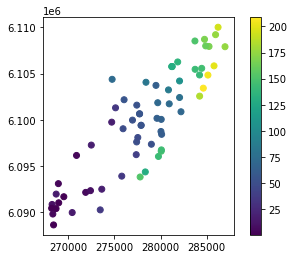

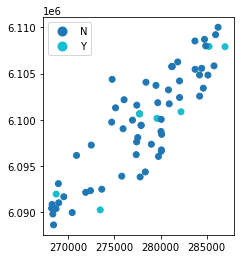

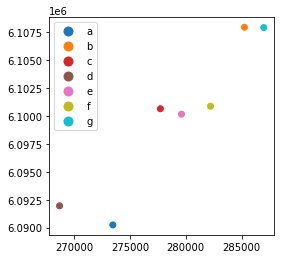

In [34]:
well_summary_gdf_ss_a1.plot(column="rswl", legend=True)
well_summary_gdf_ss_b.plot(column="dropped", legend=True)
well_summary_gdf_ss_b[well_summary_gdf_ss_b["dropped"]=="Y"].plot(column="rswl", legend=True)

### Save the dataframe


In [35]:
os.getcwd()

'C:\\Users\\mar886\\WaterTableProject\\Willunga\\willunga_wt'

In [36]:
filenm = os.path.join("output_data", "well_summary_gdf_ss_b.csv")
well_summary_gdf_ss_b.to_csv(filenm)

# Add three or so new measurements
At these points, I will ask people to guess the height of water table but we don't actually know the truth

In [37]:
well_summary_gdf_ss_b.columns

Index(['DHNO', 'Unit_No', 'Unit_Number', 'dh_name', 'network', 'Obs_No',
       'drillhole_class', 'water_point_type_code', 'Aquifer',
       'Orig_drilled_depth', 'Orig_drilled_date', 'max_drill_depth',
       'max_drill_date', 'late_open_depth', 'late_open_date', 'late_permit_no',
       'cased_to', 'case_min_diam', 'purpose', 'latest_status',
       'latest_status_date', 'dtw', 'swl', 'rswl', 'water_level_date', 'TDS',
       'EC', 'salinity_date', 'pH', 'pH_date', 'yield', 'yield_date',
       'mga_easting', 'mga_northing', 'mga_zone', 'long_degrees',
       'long_minutes', 'long_seconds', 'lat_degrees', 'lat_minutes',
       'lat_seconds', 'decimal_long', 'decimal_lat', 'neg_decimal_lat',
       'hundred', 'plan', 'parcel', 'Title', 'map_250k', 'map_100k', 'map_50k',
       'map_10k', 'map_2_5k', 'map_1k', 'water_info', 'salinity',
       'water_chemistry', 'geophys_log', 'drill_log', 'lith_log', 'geometry',
       'Datetime', 'dropped'],
      dtype='object')

In [38]:
df = pd.DataFrame({'DHNO':['new1', 'new2', 'new3'], 
                  'neg_decimal_lat':[-35.276, -35.222, -35.174],
                  'decimal_long':[138.477, 138.609, 138.478],
                  'mga_easting':[270522.908, 282386.889, 270326.409],
                  'mga_northing':[6093429.894, 6099717.867, 6104747.739],
                  'rswl':['h','i','j']})

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.mga_easting, df.mga_northing))

In [39]:
well_summary_gdf_ss_c = well_summary_gdf_ss_b.append(gdf)
print(len(well_summary_gdf_ss_b))
print(len(well_summary_gdf_ss_c))

67
70


In [42]:
a = ["N"]*(len(well_summary_gdf_ss_b)) + ["Y"]*3
print(a)

['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'Y', 'Y', 'Y']


In [43]:
well_summary_gdf_ss_c["new_well_locations"] = a

<AxesSubplot:>

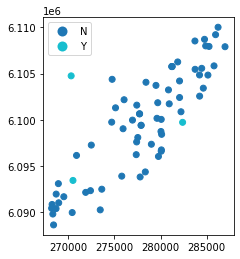

In [44]:
#well_summary_gdf_ss_c.plot(column="rswl", legend=True)
well_summary_gdf_ss_c.plot(column="new_well_locations", legend=True)

### Save the dataframe 

This is the one that I will use for the plotting exercise

In [45]:
filenm = os.path.join("output_data", "well_summary_gdf_ss_c.csv")
well_summary_gdf_ss_c.to_csv(filenm)

## Create experimental variogram

This is going to be to help us to do some form of interpolation with the data.

### Define the function

In [41]:
def make_variogram_wells(df, nbin):

    ### Matrix of the difference between distances 

    xx, xy = np.meshgrid(df["mga_easting"].to_numpy(), 
                        df["mga_easting"].to_numpy())

    dist_x = (xx - xy)**2

    #print(dist_x[:10, :10])


    yx, yy = np.meshgrid(df["mga_northing"].to_numpy(), 
                        df["mga_northing"].to_numpy())

    dist_y = (yx - yy)**2

    dxy = np.tril(np.sqrt(dist_x + dist_y)) 

    ### Matrix of the difference between values

    xv,yv = np.meshgrid(df["rswl"].to_numpy(), 
                        df["rswl"].to_numpy())

    dkv = np.tril(np.sqrt((xv-yv)**2)/2)
    #print(dkv[0:3, 0:3])

    ### Filter non-zero values and flatten array

    mask = np.nonzero(dxy*dkv) # All values in dxy and dkv that are not zero 
    dxy_masked = dxy[mask]
    dkv_masked = dkv[mask]

    ### Sort arrays (together)

    sort_ix = dxy_masked.argsort()
    dxy_sort = dxy_masked[sort_ix]
    dkv_sort = dkv_masked[sort_ix]
    ssz = int(dxy_masked.size/nbin)

    ### Create x and y values for semivariogram

    L,x,y = [0.],[],[]
    for i in range(int(len(dxy_sort)/ssz)):

        x_all = dxy_sort[i*ssz:(i+1)*ssz]    
        y_all = dkv_sort[i*ssz:(i+1)*ssz]

        x.append( np.sum(x_all)/len(x_all) )
        y.append( np.sum(y_all)/len(y_all) )
        L.append( x_all[-1] )

    x,y = np.array(x),np.array(y)

    return x, y, ssz, L

### Make the variogram by running the function

In [43]:
nbin = 100
x_wt, y_wt, ssz_wt, L_wt = make_variogram_wells(well_summary_gdf_ss_a1, nbin)

## Calculate the variance

This equals the sill - past this there should be no correlation

In [47]:
variance = np.var(well_summary_gdf_ss_a1.rswl)
print(variance)

3619.6227852880465


### Plot the experimental variogram


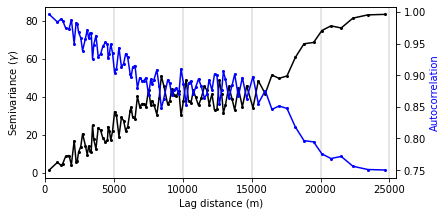

In [45]:
x = x_wt
y = y_wt
ssz = ssz_wt
L = L_wt

figx = 16.
f = plt.figure( figsize=[figx/2.54, figx/2.54/2.00] )
s = f.add_subplot(1,1,1)
s.xaxis.set_ticks_position('bottom')
s.yaxis.set_ticks_position('left')

# Plot semi-variance
s.plot( x, y, 'o-', c='k', ms=2, mec='k', mfc='k' )

# Plot autocorrelation, COVATIANCE FUNCTIO
# BUT NOTE THAT THIS IS ASSUMING STATIONARITY - NOT SURE THAT I SHOULD BOTHER PLOTTING COVARIANCE.
#s2 = s.twinx()
s2.plot( x, 1.-(y/np.var(y)), 'o-', c='b', ms=2, mec='b', mfc='b' )

# Plot set up
s.xaxis.grid(color='k', linestyle='-', lw=0.2)
s.set_xlim( -.001, L[-1]+0.001 ) 
s.set_xlabel('Lag distance (m)')
s.set_ylabel('Semivariance (${\gamma}$)', color='k')

s2.set_ylabel('Autocorrelation', color='b')

plt.savefig(os.path.join(figures_directory, "exp_variogram"))

## Model the theoretical variogram

Need to know variogram for all possible lags, distances and directions.
We can incorporate additional geological knowledge at this point.
The variogram model must be positive definite.

This variogram will be used as the basis for kriging. 

What is the nugget effect? Minor variation (smaller than spacing between points). Could be attributed to measurement error. 

Spherical: (add plot). Commonly used. Need parameter to describe the range. 